Классификация, детекция.

## Часть 1. Классификация

Обучим классификатор изображений. В датасете 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 

In [ ]:
import torch
import torchvision
import zipfile
from torch import nn
from torch.nn import functional as F
import numpy as np
import PIL
import os
import matplotlib.pyplot as plt
import sys
from os.path import isfile, join
from torchvision import transforms
device = 'cuda'

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        
        self.data_dir = os.path.expanduser(data_dir)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path):
            """
            returns all the sorted image paths.

            :param path:
            :return: лист с путями до всех изображений
            """

            images_dir = [join(path, f) for f in os.listdir(path)
                          if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(self.data_dir + '/train')
        self.labels_path = load_images(self.data_dir + '/train_masks')
        
    def __getitem__(self, idx):
        img = Image.open(self.data_path[idx])
        target = Image.open(self.labels_path[idx])
        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()

        return (img, target)


    def __len__(self, idx):
        return len(self.data_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_zip = '/content/drive/My Drive/dataset.zip'

In [ ]:
!unzip '/content/drive/My Drive/dataset.zip'

In [ ]:
train_transform = transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor()])
val_transform = transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor()])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])



In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

full = '/content/dataset/dataset/train'
train_dataset = ImageFolder(full, 
                      transform=transforms)
val_dataset = ImageFolder("/content/dataset/dataset/val", 
                      transform=Compose([Resize((224, 224)), ToTensor()]))

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: /content/dataset/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=None, contrast=None, saturation=[0.95, 1.05], hue=[-0.05, 0.05])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], resample=2, expand=False)
               ToTensor()
           )

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
len(val_dataset)

10000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


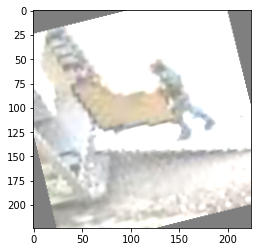

In [ ]:
i = np.random.randint(0, len(train_dataset))
image = train_dataset[i][0]
plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0", return_losses=False):

    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()          
            optimizer.step()
            optimizer.zero_grad()
            
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

def predict(model, val_dataloder, criterion, device="cuda:0", result=False):

    model = model.to(device)
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if result:
      return metrics
    if not result:
      return total_loss, total_predictions, total_labels

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    #scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(n_epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        print(train_metrics['accuracy'])
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = predict(
                model,
                val_dataloader,
                criterion,
                device,
                result=True
            )
        # Save eval losses
        print(validation_metrics['accuracy'])
        epoch_eval_losses.append(validation_metrics['loss'])

In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)

optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
#scheduler = # LR SCHEDULE THAT YOU PROBABLY CHOOSE
n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 11.7436 Accuracy: 0.0: 100%|██████████| 157/157 [00:17<00:00,  9.15it/s]
tests passed


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

Train Epoch: 0
Loss: 2.2201 Accuracy: 46.875: 100%|██████████| 1563/1563 [17:07<00:00,  1.52it/s]
0.54632
Validation Epoch: 0
Loss: 1.7535 Accuracy: 0.5625: 100%|██████████| 157/157 [00:32<00:00,  4.84it/s]
0.6312
Train Epoch: 1
Loss: 2.2058 Accuracy: 46.875: 100%|██████████| 1563/1563 [17:06<00:00,  1.52it/s]
0.54902
Validation Epoch: 1
Loss: 1.3305 Accuracy: 0.625: 100%|██████████| 157/157 [00:32<00:00,  4.85it/s]
0.6318
Train Epoch: 2
Loss: 1.6517 Accuracy: 65.625: 100%|██████████| 1563/1563 [17:07<00:00,  1.52it/s]
0.55416
Validation Epoch: 2
Loss: 1.0496 Accuracy: 0.8125: 100%|██████████| 157/157 [00:32<00:00,  4.83it/s]
0.634
Train Epoch: 3
Loss: 1.4677 Accuracy: 56.25: 100%|██████████| 1563/1563 [17:07<00:00,  1.52it/s]
0.55835
Validation Epoch: 3
Loss: 1.6535 Accuracy: 0.5: 100%|██████████| 157/157 [00:32<00:00,  4.86it/s]
0.6348
Train Epoch: 4
Loss: 1.6135 Accuracy: 56.25: 100%|██████████| 1563/1563 [17:05<00:00,  1.52it/s]
0.55953
Validation Epoch: 4
Loss: 2.0621 Accuracy: 0.

KeyboardInterrupt: ignored

После всех экспериментов которые мы проделали, выберем лучшую из моделей и запустите функцию evaluate. Эта функция берет на вход модель и даталоадер с валидационными данными и возвращает accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Loss: 1.5487 Accuracy: 0.625: 100%|██████████| 157/157 [00:15<00:00, 10.32it/s]
Оценка за это задание составит 5 баллов


In [ ]:
 accuracy

0.5208

## Часть 2. Object detection.

Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-sgzx2ebl
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-sgzx2ebl
     |████████████████████████████████| 952kB 5.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=72066 sha256=bf2da64ad76d1a52ed25db95581e03607c03c52cb8a96772f5a6079c70ef4440
  Stored in directory: /tmp/pip-ephem-wheel-cache-by84fprm/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import json
from tqdm import tqdm
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import albumentations as A
from albumentations.pytorch import ToTensor 
from torch.utils.data import Dataset, DataLoader

In [ ]:
import xmltodict, json

In [ ]:
!unzip '/content/drive/My Drive/archive.zip'

In [ ]:

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """


    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.to(device)
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
        
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
  model.to(device).train()
  n = 0
  global_loss = 0
  for images, targets in train_dataloader:
      images = list(image.to(device).float() for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      dict_loss = model(images, targets)
      losses = sum(loss for loss in dict_loss.values())

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      n += 1
      global_loss += float(losses.cpu().detach().numpy())

      if n % 10 == 0:
          print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

  return global_loss



def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {}".format(a))
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.pytorch.ToTensor() 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = FruitDataset('./train_zip/train', transform=transform)
test_ds = FruitDataset('./test_zip/test', transform=transform)

train_dataloader_2 = torch.utils.data.DataLoader(train_ds, batch_size=2, num_workers=1, shuffle=True, collate_fn=collate_fn)
test_dataloader_2 = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=1, shuffle=True, collate_fn=collate_fn)

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model(num_classes=4):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
model = get_detection_model()


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                              momentum=0.9, weight_decay=0.0005)
n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
train(model, train_dataloader_2, test_dataloader_2, optimizer, device, n_epochs)

AUC ON TEST: 0.0012567287197418468
Loss value after 10 batches is 0.67
Loss value after 20 batches is 0.58
Loss value after 30 batches is 0.52
Loss value after 40 batches is 0.48
Loss value after 50 batches is 0.43
Loss value after 60 batches is 0.39
Loss value after 70 batches is 0.38
Loss value after 80 batches is 0.37
Loss value after 90 batches is 0.36
Loss value after 100 batches is 0.35
Loss value after 110 batches is 0.34
Loss value after 120 batches is 0.33
AUC ON TEST: 0.8521398351290883
Loss value after 10 batches is 0.27
Loss value after 20 batches is 0.21
Loss value after 30 batches is 0.22
Loss value after 40 batches is 0.21
Loss value after 50 batches is 0.21
Loss value after 60 batches is 0.2
Loss value after 70 batches is 0.21
Loss value after 80 batches is 0.2
Loss value after 90 batches is 0.19
Loss value after 100 batches is 0.19
Loss value after 110 batches is 0.19
Loss value after 120 batches is 0.19
AUC ON TEST: 0.9087102533781545
Loss value after 10 batches is 0.

Нарисуем предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
image, labels = next(iter(train_ds))
pred = model(image.unsqueeze(0).to(device))[0]

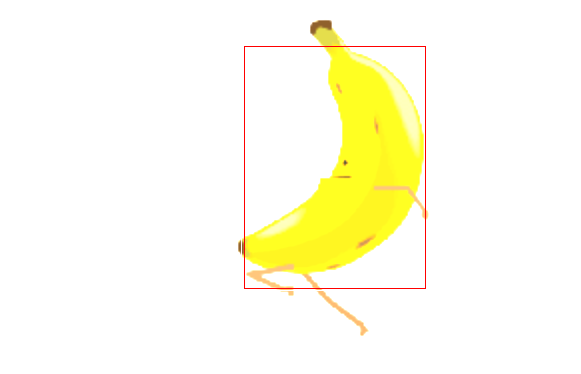

In [ ]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

In [ ]:
print(accuracy, 'легко, не почувствовал')

0.5208 легко, не почувствовал


Вначале пробовал алекснет, потому что он самый простой и гоняется быстрее. Но он не обучался от слова совсем
потом вгг, потому что он тоже простой, понакрученнее алекснета притом разные вгг. Он тоже не обучался, качество ни на трейне ни на валидации просто не росло 
В итоге попробовал резнет18, скачал предобученную, обучал только последний слой, потому что он еще сильнее, хоть и по времени больше займет. К сожалению, и он не сработал вначале и модель по прежнему не обучалась. 

Каждый раз был ноль на валидации, а на трейне было 4 значения, которые просто друг за другом сменялись. ничего не происходило со сменой эпох. было очень грустно

Потом попробовал resnext, там предобученные веса заняли 15гб на гпу, либо я как-то его сломал)))
не сработало очевидно

потом я вернулся к резнет18, так как она по-хорошему должна хорошо пробивать классификацию.
выкинул половину классов в трейне, чтобы посмотреть обучается ли оно вообще, ну и чтобы было быстрее, пофиксить все ошибки
также попробовал обучать не последний слой, а все. Обучение пошло.
после этого я еще добавил аугментацию, для улучшения качества и взял полный датасет
это был мой мучительный и долгий путь к успеху